In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy
import copy

In [2]:
np.random.seed(13)

# 0. Introduction

This notebook is supposed to demonstrate the process of Bayesian Optimization. 
This process consists of the following steps:

1. Definition of the test function
2. Design of Experiments
3. Gaussian Process Regression
4. Bayesian Optimization loop


# 1. Test function

First, let's examine the test function used in this tutorial. The overall approach doesn't change for different test functions, but implementation details (e.g. the kernel function) might need adaptions. 

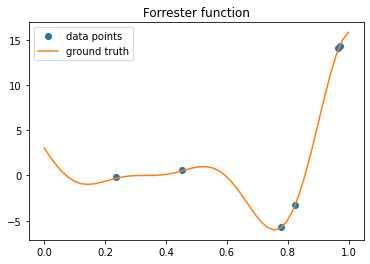

In [3]:
N_grid = 50
xmin = 0
xmax = 1

x = np.linspace(xmin, xmax, N_grid)

def test_func(x, noise_lvl=0.):
    return (6*x - 2)**2 * np.sin(12*x - 4) + np.random.normal(0, 1, x.shape)*noise_lvl

# Training Data
N_data = 6
x_data = np.sort(np.random.rand(N_data)*(xmax-xmin) + xmin)
x_data = x_data[:, np.newaxis]


y_data = test_func(x_data[:,0], 0.1)[:, np.newaxis]

plt.plot(x_data, y_data, 'o', label="data points")
plt.plot(x, test_func(x), '-', label="ground truth")
plt.gca().set_title("Forrester function")
plt.legend()

# 2. Design of Experiments (DoE)

To build a model, we first need to generate some data. For this reason, we need to decide where to sample our 'probing points'. Because evaluating the test function is usually expensive in real world applications, it is advisable to spend some thought, on how to distribute these sampling points. We want to gain as much information about the test function as possible while using as few samples as necessary.

Let's consider three different possibilities of generating the sample points:
1. Random Sampling
2. Latin Hypercube Sampling (LHS)
3. Sampling using a Sobol sequence

In [4]:
# import LHS and Sobol sampler

from scipy.stats.qmc import LatinHypercube, Sobol   # only available in scipy 1.7.0 and higher


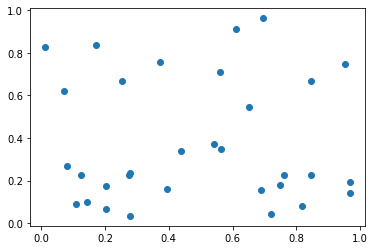

In [5]:
N_samples = 32

x_rs = np.random.uniform(size=(N_samples,2))
plt.plot(x_rs[:,0], x_rs[:,1], 'o')
# plt.set_xlim([0, 1])
# plt.set_ylim([0, 1])

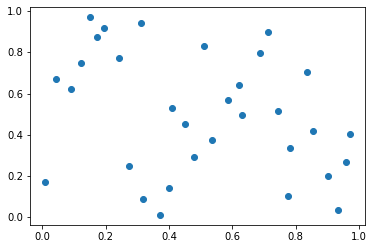

In [6]:
sampler_lhs = LatinHypercube(d=2)

x_lhs = sampler_lhs.random(n=N_samples)

plt.plot(x_lhs[:,0], x_lhs[:,1], 'o')

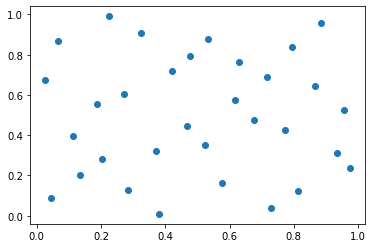

In [7]:
sampler_sobol = Sobol(d=2)

x_sobol = sampler_sobol.random(n=N_samples)

plt.plot(x_sobol[:,0], x_sobol[:,1], 'o')

# 3. Gaussian Process Regression

The main ingredient of Bayesian Optimization is Gaussian Process Regression. This will give us a model to predict values of the test function, and also a measure of uncertainty for that prediction. We will use both to improve the model and the location of the best known solution.

## 3.1 The kernel function

The kernel defines the probabilistic model - what kind of functions are more likely than others.
There are multiple kinds of kernel functions one can use to model different kinds of functions.
It is also possible to combine multiple kernels by multiplication or addition.
For our use case the RBF kernel (also called Squared Exponential (SE) or Gaussian kernel) will be enough:

$$ k_{RBF}(\boldsymbol x, \boldsymbol x', \boldsymbol \theta) = \exp{ \left[ - \sum_{i=1}^D \theta_i \cdot (x_i - x_i')^2  \right] }$$

Hint: For input dimensions $D > 1$ the parameter $\boldsymbol \theta$ can either be a single number or a vector of size $D$ with one $\theta_i$ per input dimension. The latter variant is called 'Automatic Relevance Detection' and is especially useful, if the input dimensions are unequally scaled.


In [8]:
def kernel_func(x1, x2, theta, p=2):
    if type(x1) is np.ndarray:
        # Input is multidimensional (D>1)
        assert len(x1) == len(theta), f"Lengths: {len(x1)} {len(theta)} "
        assert type(x2) is np.ndarray
        assert x1.shape == x2.shape

        D = len(x1) # dimesionality of the input x
        cor = np.sum( [ float(theta[i]) * np.power( float(x1[i]-x2[i]), p ) for i in range(D) ] )

        # the  last line is equal to the following code:
        # cor = 0.
        # for i in range(d):
        #     cor += float(theta[i]) * np.power( float(x1[i]-x2[i]), p)
    else:
        cor = float(theta) * np.power( float(x1-x2), p )
    
    cor = np.exp(-float(cor))
    
    return cor

In [9]:
# kernel_func works with one-dimensional input

x1 = 0.0
x2 = 0.24
theta = 2.4

kernel_func(x1, x2, theta)

0.8708896531454148

In [10]:
# ... and multi-dimensional input, too

x1 = np.array([0., 0.3], dtype=np.float64)
x2 = np.array([0.7, 0.1], dtype=np.float64)
theta = np.array([0.1, 1.0], dtype=np.float64)

kernel_func(x1, x2, theta)

0.914845573574452

Now we can use this kernel function to calculate the 'covariance matrix' $\boldsymbol K^{\boldsymbol \theta, \alpha}$ of the data:

$$ K_{ij}^{\boldsymbol \theta, \alpha} = k(x_i, x_j, \boldsymbol \theta) + \alpha \boldsymbol I $$

Notice that the matrix $\boldsymbol K^{\boldsymbol \theta, \alpha}$ depends on the input coordinates $\boldsymbol X$ (not on the output values $\boldsymbol Y$) and the hyperparameters $\boldsymbol \theta$ and $\alpha$. The python function takes $\log \boldsymbol \theta$ and $\log \alpha$ as input parameters, because this will make hyperparameter tuning easier. 

The 'regularization parameter' $\alpha$ represents measurement noise on the given data (you can try out different values) and will also help to ensure that the covariance matrix is postive (semi-)definite. So even if the data should be free of noise, it can help to set $\alpha$ to small non-zero values, so that numerical issues are avoided.

Also please make sure that important variables like $\boldsymbol K$ are of type np.float64 (=double precision). This basically means that more memory is used to accurately represent these variables. In the past single precision (float32) has been the default data type for floating point numbers in numpy. In more recent numpy versions float64 should already be the default, but please make sure your variables are set to double precision, so that your inference algorithm is as accurate and stable as possible.

In [11]:
def get_correlation_matrix(x, logTheta=1., logRegPara=None):
    """
    Returns the full covariance matrix of input data x
    """
    # reg has to be None or float.

    theta = np.power(10, logTheta)
    if logRegPara is not None:
        regPara = np.power(10, logRegPara)
    else:
        regPara = 0

    N, D = x.shape
    #print(N, D)

    K = np.empty((N, N), dtype=np.float64)
    for i in range(N):
        for j in range(N):
            K[i,j] = kernel_func(x[i], x[j], theta)
        K[i,i] += regPara

    return K

The following cell shows the structure of the covariance matrix $\boldsymbol K$:

(6, 6)

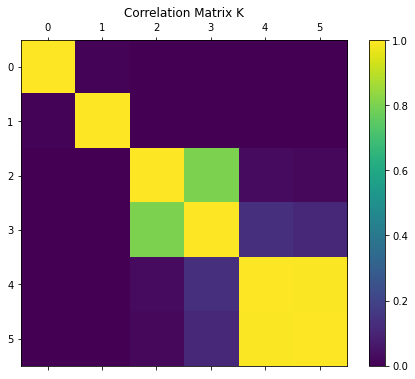

In [12]:
#logTheta = np.array([0.1])
logTheta = [2.]
logRegPara = -3.

K = get_correlation_matrix(x_data, logTheta, logRegPara)

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ms = ax.matshow(K)
plt.colorbar(ms, ax=ax)
plt.title("Correlation Matrix K")

K.shape

In [13]:
K

array([[1.00100000e+00, 9.45106705e-03, 2.13015561e-13, 1.11930616e-15,
        9.33113174e-24, 3.42375354e-24],
       [9.45106705e-03, 1.00100000e+00, 2.71533160e-05, 1.06617202e-06,
        3.99841157e-12, 1.97221064e-12],
       [2.13015561e-13, 2.71533160e-05, 1.00100000e+00, 8.04983487e-01,
        2.91249691e-02, 2.24032228e-02],
       [1.11930616e-15, 1.06617202e-06, 8.04983487e-01, 1.00100000e+00,
        1.35146633e-01, 1.10807722e-01],
       [9.33113174e-24, 3.99841157e-12, 2.91249691e-02, 1.35146633e-01,
        1.00100000e+00, 9.95316129e-01],
       [3.42375354e-24, 1.97221064e-12, 2.24032228e-02, 1.10807722e-01,
        9.95316129e-01, 1.00100000e+00]])

Like shown in tutorial notebook 05, we can draw samples from this probabilistic model of our data and plot those samples. We can use this, to see if our model adequately captures the properties of the underlying data. If our model is adequate, it should be quite difficult to distinguish between the 'fake' sampled data and the true data.



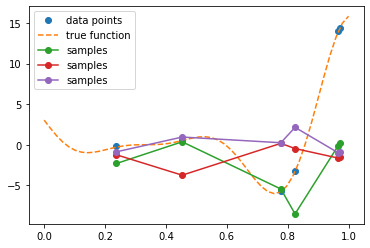

In [14]:
# from the normal distribution (0, K) a random vector can be drawn by using Cholesky factorization:
mu = np.zeros_like(x_data)  # prior mean values are 0

L = np.linalg.cholesky(9*K) # the value 9 represents a guess for sigma^2
z = np.random.normal(0,1, (len(mu), 3))

rv_samples = L @ z + mu
rv_samples.shape

plt.plot(x_data, y_data, 'o', label="data points")
plt.plot(x, test_func(x), '--', label="true function")
plt.plot(x_data, rv_samples, "o-", label="samples")
plt.legend();

## 3.2 Bayesian inference

The predicted mean and variance values at $x_i$ are given by the following formulas:

$$ \mu_n (x) = k(\boldsymbol x)^T \boldsymbol K^{-1} \boldsymbol Y $$

$$ \sigma_n^2 (x) = \hat{\sigma}^2 \left( 1 - k(\boldsymbol x)^T \boldsymbol K^{-1} k(\boldsymbol x) \right) $$ 



The optimal value of $\hat{\sigma}^2$ can be analytically determined by maximum likelihood:

$$ \hat{\sigma}_{MLE}^2 (\boldsymbol \theta) = \frac{\boldsymbol Y^T \boldsymbol K^{-1} \boldsymbol Y}{N} $$

In [15]:
logTheta = [2.]
logRegPara = -3.

theta = np.power(10, logTheta)
regPara = np.power(10, logRegPara)

K = get_correlation_matrix(x_data, logTheta, logRegPara)

xpre = x
Npre = xpre.shape[0]

The terms $\boldsymbol K^{-1} \boldsymbol Y$ and $\boldsymbol K^{-1} k(\boldsymbol x)$ can be computed numerically efficient by using LU decomposition.

$$w = \boldsymbol K^{-1} \boldsymbol Y $$
$$\Rightarrow \boldsymbol LU w =  \boldsymbol Y$$

In [16]:
# LU decomposition of K
luK = scipy.linalg.lu_factor(K)

# compute the solution to K*weights = y_data
weights = scipy.linalg.lu_solve(luK, y_data) 


In [17]:
luK

(array([[ 1.00100000e+00,  9.45106705e-03,  2.13015561e-13,
          1.11930616e-15,  9.33113174e-24,  3.42375354e-24],
        [ 9.44162542e-03,  1.00091077e+00,  2.71533160e-05,
          1.06617202e-06,  3.99841157e-12,  1.97221064e-12],
        [ 2.12802758e-13,  2.71286082e-05,  1.00100000e+00,
          8.04983487e-01,  2.91249691e-02,  2.24032228e-02],
        [ 1.11818797e-15,  1.06520187e-06,  8.04179308e-01,
          3.53648936e-01,  1.11724936e-01,  9.27915142e-02],
        [ 3.42033320e-24,  1.97041606e-12,  2.23808420e-02,
          2.62383128e-01,  9.65349549e-01,  9.76151669e-01],
        [ 9.32180993e-24,  3.99477326e-12,  2.90958733e-02,
          3.15920464e-01,  9.99489139e-01, -1.03034427e-02]]),
 array([0, 1, 2, 3, 5, 5], dtype=int32))

With this, $\mu_n (x)$ can be determined:

In [18]:
ypre  = np.empty(Npre, dtype=np.float64)

for n in range(Npre):
    k = np.empty(N_data, dtype=np.float64)
    for i in range(N_data):
        k[i] = kernel_func(np.atleast_1d(xpre[n]), np.atleast_1d(x_data[i]), theta)        # so, switch-off the reg value because it is always for "new" prediction.
    
    ypre[n] = np.dot( k, weights )

ypre

array([-6.10071076e-04, -1.54299499e-03, -3.59063706e-03, -7.68776448e-03,
       -1.51442212e-02, -2.74475942e-02, -4.57670724e-02, -7.02017139e-02,
       -9.90324258e-02, -1.28402816e-01, -1.52787895e-01, -1.66237014e-01,
       -1.63871867e-01, -1.42856318e-01, -1.02333425e-01, -4.25680042e-02,
        3.57638386e-02,  1.31140788e-01,  2.39433727e-01,  3.51871609e-01,
        4.54552827e-01,  5.30838317e-01,  5.66289646e-01,  5.53956052e-01,
        4.97096989e-01,  4.07458808e-01,  2.99335941e-01,  1.81424673e-01,
        4.90008547e-02, -1.21416538e-01, -3.72865990e-01, -7.61528677e-01,
       -1.34031500e+00, -2.13247403e+00, -3.10193200e+00, -4.13454252e+00,
       -5.04589504e+00, -5.62128440e+00, -5.67454372e+00, -5.09718442e+00,
       -3.87197296e+00, -2.04848988e+00,  2.92810697e-01,  3.05098288e+00,
        6.07327073e+00,  9.10626682e+00,  1.17818769e+01,  1.36791911e+01,
        1.44542805e+01,  1.39766237e+01])

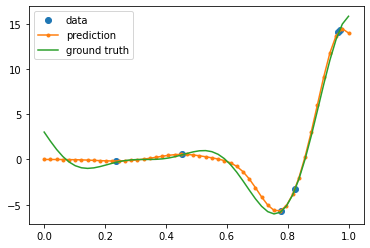

In [19]:
plt.plot(x_data, y_data, 'o', label='data')
plt.plot(xpre, ypre, '.-', label='prediction')
plt.plot(xpre, test_func(xpre), label="ground truth")

plt.legend()

In [20]:
xpre

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

Now for the uncertainty (variance) of the prediction:

$$ \hat{\sigma}_{MLE}^2 (\boldsymbol \theta) = \frac{\boldsymbol Y^T \boldsymbol K^{-1} \boldsymbol Y}{N} $$

In [21]:
var_mle = np.diag(np.dot(y_data.T, weights)) / float(N_data)


$$ \sigma_n^2 (x) = \hat{\sigma}^2 \left( 1 - k(\boldsymbol x)^T \boldsymbol K^{-1} k(\boldsymbol x) \right) $$ 

In [22]:
yvar = np.empty(Npre, dtype=np.float64)

for n in range(Npre):
    k = np.empty(N_data, dtype=np.float64)
    for i in range(N_data):
        k[i] = kernel_func(np.atleast_1d(xpre[n]), np.atleast_1d(x_data[i]), theta)    
    
    weights_var = scipy.linalg.lu_solve(luK, k)
    yvar[n] = np.abs(var_mle * (1. - np.dot(k, weights_var)))

yvar

array([40.96540375, 40.96262988, 40.94811327, 40.88429829, 40.6491753 ,
       39.92535911, 38.07207843, 34.15305615, 27.38805479, 18.05836655,
        8.24926579,  1.41102028,  0.48101304,  5.87147896, 15.12424391,
       24.51096231, 31.00513884, 33.07099199, 30.334975  , 23.30453176,
       13.7211532 ,  4.79367445,  0.2039506 ,  2.06741452,  9.54163585,
       19.4757377 , 28.52438171, 34.86531635, 38.41621197, 39.98142171,
       40.31915774, 39.62504228, 37.40738082, 32.74960547, 25.12995962,
       15.54645797,  6.74648613,  1.48442038,  0.05173303,  0.20292783,
        0.08786911,  0.29984377,  2.03621595,  4.35379502,  4.99387855,
        3.42713641,  1.31918758,  0.15770993,  0.18028458,  1.76915533])

The following graph shows the mean and standard deviation of the infered prediction:

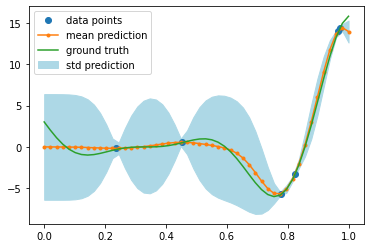

In [23]:
ypreU = ypre + np.sqrt(yvar)
ypreL = ypre - np.sqrt(yvar)

plt.plot(x_data, y_data, 'o', label='data points')
plt.plot(xpre, ypre, '.-', label='mean prediction')
plt.plot(xpre, test_func(xpre), label="ground truth")
plt.fill_between(xpre, ypreU, ypreL, color="lightblue", label="std prediction")

plt.legend()

## 3.3 Hyperparameter tuning

To find appropriate values for the hyperparameters, we can use the marginal log-likelihood of the data $(\boldsymbol X, \boldsymbol Y)$. Because we only are interested in the $argmax$ of the likelihood function, constant terms can be ignored:

$$ E(\boldsymbol \theta, \alpha) = \frac{N}{2} \ln{\hat{\sigma}_{MLE}^2(\boldsymbol \theta, \alpha)} + \frac{1}{2} \ln \vert  \boldsymbol K(\boldsymbol \theta, \alpha) \vert + C $$


Using the LU decomposition $\boldsymbol K = L U$ with lower  and upper triangular matrices $L$ and $U$, the term $\ln \vert \boldsymbol K(\boldsymbol \theta, \alpha) \vert $ can be efficiently computed from the diagonals of $L$ and $U$:

$$ \vert \boldsymbol K(\boldsymbol \theta, \alpha) \vert = \vert L \vert \cdot \vert U \vert = \left( \prod_{i=1}^N l_{ii}  \right)  \cdot \left( \prod_{i=1}^N u_{ii}  \right) $$

$$ \Rightarrow  \ln \vert \boldsymbol K(\boldsymbol \theta, \alpha) \vert = \sum_{i=1}^N \ln{l_{ii}} + \sum_{i=1}^N \ln{u_{ii}}$$

In [24]:
def mll(hyperparameters, x_data, y_data, verbose=False):
    N_data, D = x_data.shape
    
    if verbose:
        print(hyperparameters)
    
    logTheta = hyperparameters[:-1]
    logRegPara = hyperparameters[-1]
    
    K = get_correlation_matrix(x_data, logTheta, logRegPara)
    
    luK = scipy.linalg.lu_factor(K)    
    weights = scipy.linalg.lu_solve(luK, y_data)   # different from w
    var_mle = np.dot(y_data.T, weights) / float(N_data)
    lnK = np.sum(np.log(np.fabs(np.diag(luK[0]))))      # this function calculates the log-determinant of K in a numerically efficient and stable way

    # _, lnK2 = np.linalg.slogdet(K) # alternative way to compute the log-determinant (less efficient, because LU factorization is repeated in slogdet)
    # if verbose:
    #     print("lnK:", lnK, lnK2)
    
    if verbose:
        print(var_mle, np.exp(lnK))
    
    if var_mle > 0:
        E = N_data*np.log(var_mle) + lnK  
    else:
        return 1e6 # return high value, so optimization is steered away from invalid values
    
    if verbose:
        print(E)
        print()
    
    return E.flatten()

Now we can use this function to find suitable hyperparameters. Because this is not a course on optimization, we will just use an off-the-shelf method from scipy.optimize. The likelihood function can be a bit difficult to optimize (to be more technical: it is usually non-convex) and therefore gradient based methods like gradient descent might converge to a suboptimal solution. For this reason we use the global optimizer 'differential_evolution' (although there is no free lunch and this method might encounter difficulties a well - please make sure to always check your optimization results for plausibility, and re-run the process if necessary)

In [25]:
args = (x_data, y_data) # arguments that are given to the optimizer function and don't change during the optimization run

tol = 0.001         # convergence criterium
maxiter = 1000      # maximum number of iterations of the optimization algorithm
bounds = np.array([[-5, 5], [-9, 3]])   # bounds for the variables to be optimized. The values will stay in these intervals

In [26]:
# run the optimization
opt = scipy.optimize.differential_evolution(mll, bounds=bounds, args=args, maxiter=maxiter, tol=tol, disp=True)
opt

differential_evolution step 1: f(x)= 15.2373
differential_evolution step 2: f(x)= 15.2373
differential_evolution step 3: f(x)= 15.2373
differential_evolution step 4: f(x)= 15.0054
differential_evolution step 5: f(x)= 15.0054
differential_evolution step 6: f(x)= 15.0054
differential_evolution step 7: f(x)= 15.0054
differential_evolution step 8: f(x)= 15.0046
differential_evolution step 9: f(x)= 15.0046
differential_evolution step 10: f(x)= 15.0046


     fun: array([15.00461887])
     jac: array([-5.86197761e-06,  2.84217096e-05])
 message: 'Optimization terminated successfully.'
    nfev: 342
     nit: 10
 success: True
       x: array([ 1.64125071, -7.78525363])

In [27]:
# get the results
hyperparameters = opt.x

logTheta = hyperparameters[:-1]
logRegPara = hyperparameters[-1]

theta = np.power(10, logTheta)
regPara = np.power(10, logRegPara)

theta, regPara

(array([43.77747466]), 1.639631957465694e-08)

For readibility and ease of use, the inference steps can be put into a separate function:

In [28]:
def predict_output(xpre, x_data, y_data, theta, regPara, verbose=False):

    N_data, D_input = x_data.shape
    Npre = xpre.shape[0]

    # this part could also be reused / done outside of this function 
    K = get_correlation_matrix(x_data, logTheta, logRegPara)    
    luK = scipy.linalg.lu_factor(K)    
    weights = scipy.linalg.lu_solve(luK, y_data)   # different from w
    var_mle = np.diag(np.dot(y_data.T, weights)) / float(N_data)
    if verbose:
        print("var_mle:", var_mle)
    
    ypre  = np.empty(Npre, dtype=np.float64)
    yvar = np.empty(Npre, dtype=np.float64)

    for n in range(Npre):
        k = np.empty(N_data, dtype=np.float64)
        for i in range(N_data):
            k[i] = kernel_func(np.atleast_1d(xpre[n]), np.atleast_1d(x_data[i]), theta)        # so, switch-off the reg value because it is always for "new" prediction.
        
        ypre[n] = np.dot( k, weights )

        weights_var = scipy.linalg.lu_solve(luK, k)
        yvar[n] = np.abs(var_mle * (1. - np.dot(k, weights_var)))
    
    return ypre, yvar

Let's check the result:

var_mle: [49.9539785]


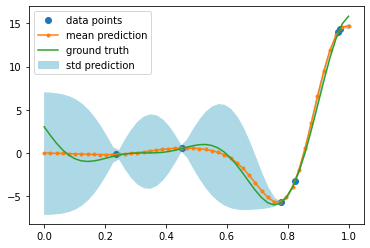

In [29]:
ypre, yvar = predict_output(np.atleast_1d(xpre), x_data, y_data, theta, regPara, True)

ypreU = ypre + np.sqrt(yvar)
ypreL = ypre - np.sqrt(yvar)

#plt.plot(x_data, y_data, 'o', label='data')
plt.plot(x_data[:10,:], y_data[:10,:], 'o', label='data points')
plt.plot(xpre, ypre, '.-', label='mean prediction')
plt.plot(xpre, test_func(xpre), label="ground truth")
plt.fill_between(xpre, ypreU, ypreL, color="lightblue", label="std prediction")

plt.legend()

# 4. Bayesian optimization loop

## 4.1 Acquisition function

Multiple acquisition functions have been developed. Two of the most widely used acquisition functions are 'Probability of Improvement' and 'Expected Improvement'. In this tutorial we will use variance reduction, which can be useful if the goal is to learn the data generating function as well as possible. Generally speaking, acqusition functions balance exploitation (optimization of the best mean value) and exploration (variance reduction). 

In [30]:
def acquisition(ypre, yvar):
    # this acquisition function is very simple
    # this can be substituted by more complicated functions computed from the inputs ypre and yvar 

    a = -yvar

    return a

def af_opt_func(xpre, theta, regPara, x_data, y_data):    
    # this 'wrapper' function will be used to interact with the scipy.optimize method

    ypre, yvar = predict_output(np.atleast_2d(xpre), x_data, y_data, theta, regPara)

    a = acquisition(ypre, yvar)

    return a

In [31]:
# test some value
af = af_opt_func(0.1, theta, regPara, x_data, y_data)

The acquisition function can be nicely visualized next to the GP regression model:

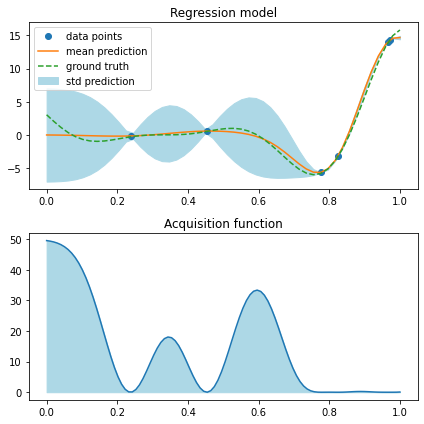

In [32]:
x_test = np.linspace(0, 1, 100)[:, np.newaxis]
af_values = -af_opt_func(x_test, theta, regPara, x_data, y_data)

ypreU = ypre + np.sqrt(yvar)
ypreL = ypre - np.sqrt(yvar)

fig, ax = plt.subplots(2, figsize=(6,6))

ax[0].plot(x_data, y_data, 'o', label='data points')
ax[0].plot(xpre, ypre, '-', label="mean prediction")
ax[0].fill_between(xpre, ypreU, ypreL, color="lightblue", label="std prediction")
ax[0].plot(xpre, test_func(xpre), '--', label="ground truth")
ax[0].set_title("Regression model")
ax[0].legend()

ax[1].plot(x_test, af_values)
ax[1].fill_between(x_test[:,0], af_values, 0, color="lightblue")
ax[1].set_title("Acquisition function")
#ax[1].legend()

fig.tight_layout();

## 4.2 Deciding where to probe next

Now we just need to find the point $x_{next}$ which maximizes the acquisition function:

In [33]:
# one possibility: selecting the highest value from a grid
i_next = np.argmax(af_values)
i_next, af_values[i_next], x_test[i_next]

(0, 49.59070508250935, array([0.]))

In [34]:
# or just use scipy.optimize again
args = (theta, regPara, x_data, y_data)

opt = scipy.optimize.differential_evolution(af_opt_func, bounds=[[0, 1]], args=args, maxiter=100, tol=0.001, disp=True)
opt.x

differential_evolution step 1: f(x)= -49.5324
differential_evolution step 2: f(x)= -49.5324
differential_evolution step 3: f(x)= -49.5324
differential_evolution step 4: f(x)= -49.5427
differential_evolution step 5: f(x)= -49.5894
differential_evolution step 6: f(x)= -49.5894
differential_evolution step 7: f(x)= -49.5896
differential_evolution step 8: f(x)= -49.5896
differential_evolution step 9: f(x)= -49.5896
differential_evolution step 10: f(x)= -49.5896


array([0.])

In [35]:
x_next = opt.x
y_next = test_func(x_next)
x_next, y_next 

(array([0.]), array([3.02720998]))

## 4.3 Closing the loop

After finding the best probing point, we just need to evaluate the data generating process at $x_{next}$ to get $y_{next}$ and append these values to our data set. Then we can repeat the process:
1. Fit the hyperparameters of the probabilistic model (GP) to the data
2. Maximize the acquisiton function
3. Generate new data point(s)
4. Save results
5. Go back to step 1

In [36]:
x_data_new = np.vstack((x_data, x_next))
y_data_new = np.vstack((y_data, y_next))
x_data_new, y_data_new

(array([[0.23754122],
        [0.45344925],
        [0.77770241],
        [0.82427853],
        [0.9657492 ],
        [0.97260111],
        [0.        ]]),
 array([[-0.16694607],
        [ 0.56829295],
        [-5.65043364],
        [-3.22755023],
        [14.04349034],
        [14.3623046 ],
        [ 3.02720998]]))

In [37]:
def tune_hyperparameters(x_data, y_data, hyperparameters_restart=None):
    args = (x_data, y_data)
    tol = 0.001
    maxiter = 1000
    bounds = np.array([[-5, 5], [-9, 3]])
    opt = scipy.optimize.differential_evolution(mll, bounds=bounds, args=args, maxiter=maxiter, tol=tol, disp=False, x0=hyperparameters_restart)
    
    print("likelihood:", opt.fun)

    hyperparameters = opt.x

    logTheta = hyperparameters[:-1]
    logRegPara = hyperparameters[-1]

    theta = np.power(10, logTheta)
    regPara = np.power(10, logRegPara)

    return theta, regPara, hyperparameters

In [38]:
def find_next_point(theta, regPara, x_data, y_data):
    
    args = (theta, regPara, x_data, y_data)

    opt = scipy.optimize.differential_evolution(af_opt_func, bounds=[[0, 1]], args=args, maxiter=100, tol=0.001, disp=False)

    return opt.x

In [39]:
def plot_progress(x_data, y_data, xpre, ypre, yvar, x_test, af_values, ax_pre, ax_af, x_next, y_next):

    #xpre, ypre, yvar, x_test, af_values, ax_pre, ax_af, x_next, y_next = 
    
    x_data = copy.deepcopy(x_data)
    y_data = copy.deepcopy(y_data)
    xpre = copy.deepcopy(xpre)
    ypre = copy.deepcopy(ypre)
    yvar = copy.deepcopy(yvar)
    x_test = copy.deepcopy(x_test)
    af_values = copy.deepcopy(af_values)
    x_next = copy.deepcopy(x_next)
    y_next = copy.deepcopy(y_next)

    ypreU = ypre + np.sqrt(yvar)
    ypreL = ypre - np.sqrt(yvar)


    ax_pre.plot(x_data, y_data, 'o', label="data points")
    ax_pre.plot(x_next, y_next, 'o', color="red", label="next point")
    ax_pre.axvline([x_next], ls=':', color="red")
    ax_pre.plot(xpre, ypre, '-', label="mean prediction")
    ax_pre.fill_between(xpre, ypreU, ypreL, color="lightblue", label="std prediction")
    ax_pre.plot(xpre, test_func(xpre), '--', label="ground truth")
    ax_pre.set_title("Regression model")
    ax_pre.legend(loc="upper left")

    ax_af.plot(x_test, af_values, label="acquisition func")
    ax_af.fill_between(x_test[:,0], af_values, 0, color="lightblue")
    ax_af.axvline([x_next], ls=':', color="red", label="max")
    ax_af.set_title("Acquisition function")
    ax_af.legend(loc="upper left")

iter 1
likelihood: [18.03383781]
theta, regPara: [45.74842525] 6.6224551834094056e-09
next point: [0.59522957] [-0.00286964]
var_mle: [44.15439698]
iter 2
likelihood: [20.36360186]
theta, regPara: [43.6594455] 8.850304490802993e-09
next point: [0.1182609] [-0.88556313]
var_mle: [38.6469166]
iter 3
likelihood: [22.50298718]
theta, regPara: [42.68645669] 5.71363083801047e-08
next point: [0.34789928] [0.00132827]
var_mle: [35.6205389]
iter 4
likelihood: [23.70677842]
theta, regPara: [39.45529159] 3.214445595528135e-08
next point: [0.67641569] [-3.50824298]
var_mle: [32.30964547]


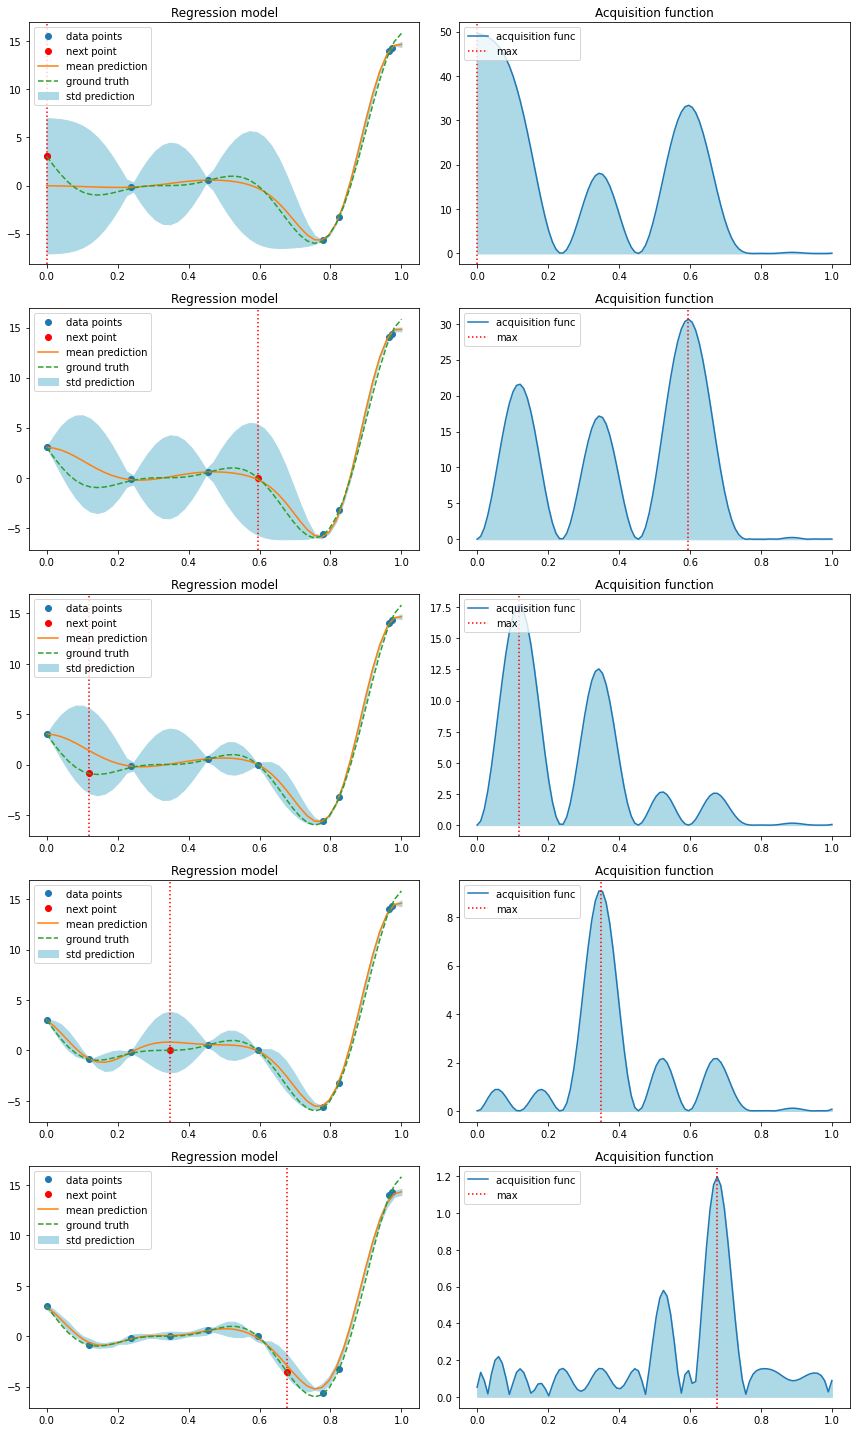

In [40]:
bayesopt_maxiter = 5

fig, axes = plt.subplots(bayesopt_maxiter, 2, figsize=(12, 4*bayesopt_maxiter))

ax_pre = axes[0,0]
ax_af = axes[0,1]
plot_progress(x_data_new, y_data_new, xpre, ypre, yvar, x_test, af_values, ax_pre, ax_af, x_next, y_next)

hyperparameters_restart = None

for i in range(1, bayesopt_maxiter):
    print("iter", i)

    # fit model to data
    theta, regPara, hyperparameters_restart = tune_hyperparameters(x_data_new, y_data_new)
    print("theta, regPara:", theta, regPara)
    
    x_next = find_next_point(theta, regPara, x_data_new, y_data_new)
    y_next = test_func(x_next)
    print("next point:", x_next, y_next)

    ypre, yvar = predict_output(xpre, x_data_new, y_data_new, theta, regPara, True)
    af_values = -af_opt_func(x_test, theta, regPara, x_data_new, y_data_new)
    
    ax_pre = axes[i,0]
    ax_af = axes[i,1]
    plot_progress(x_data_new, y_data_new, xpre, ypre, yvar, x_test, af_values, ax_pre, ax_af, x_next, y_next)

    x_data_new = np.vstack((x_data_new, x_next))
    y_data_new = np.vstack((y_data_new, y_next))

fig.tight_layout()

plt.show()

# 5. Further topics

What parts of the GPR process are computationally expensive? How could these parts be reused?

In [41]:
class Kernel:

    def __init__(self):
        self.state = 0

    def lu_decomposition(self, x_data):
        self.luK = ...
    
    def get_luK(self):
        return self.luK

    